# MAPseq Data Analysis

In this notebook, This protocol will guide you through the steps for turning raw sequencing reads into a viral barcode matrix, which you can then analyze yourself or in conjunction with BARseq data, as we will do in this course. 

# Imports

In [29]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

from mapseq.core import *
from mapseq.barcode import *
from mapseq.utils import *
from mapseq.bowtie import *
from mapseq.stats import *

gitpath=os.path.expanduser("~/git/mapseq-analysis")
sys.path.append(gitpath)

from msanalysis.analysis import * 

print("Done")

Done


# Overview

The overall goal is to take the paired-end RNA sequencing FASTQ data and produce a correct matrix of viral barcodes and their projections to dissected areas. This is implemented as a pipeline of functions, with the first consuming the FASTQs and the others consuming the output of the previous step, until the final step produces the matrices.  

![title](img/mapseq-processing-schema-api.png)

# Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the path to the a standard Python configuration file, and a standard sample information Excel spreadsheet. We also have a convenience method to package up the FASTQ file pairs.  

This is an example sample info spreadsheet. 

![title](img/sampleinfo.png)

The Site information column should indicate whether the dissected area is a target or injection, and additionally whether it is a negative (biological control) or control (water). 
Region and Brain should be obvious. Note that the region labels will be used (if available) for the default plots.  

The RT primer barcode table is included in the software, as ~/git/mapseq-processing/etc/barcodes_v2.txt

By default, functions in the pipeline take their parameters from a single configuration file, included in the distribution ~/git/mapseq-processing/etc/mapseq.conf. If you want to perform processing with parameters other than the defaults, then copy the config in the distrubtion, edit it, and use it instead. For some functions, parameters can be overridden in the function call itself.  

Here are a couple example sections of the configuration file. We will revisit it for each function in more detail. 

![title](img/mapseq-config.png)

A configuration file simply has sections, within which there are key-value pairs. These values can be retrieved by the ConfigParser interface.  


In [31]:
#cp = get_default_config()
configfile = os.path.expanduser('~/project/mapseq/M205.htna24/M205.mapseq.conf')
cp = ConfigParser()
cp.read(configfile)
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M205.htna24/M205_sampleinfo.xlsx')
expid = 'M205.htna24'
bcfile = os.path.expanduser( cp.get('barcodes','ssifile') )
 
infilelist = [
    os.path.expanduser('~/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz')
          ]
infiles = package_pairfiles(infilelist)
outdir = os.path.expanduser('~/project/mapseq/M205.htna24')
print(f"For {expid}:\nconfig={configfile}\nbcfile={bcfile}\ninfiles={infiles}\noutdir={outdir}")

INFO:root:input pair of readfiles: r1=/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz r2=/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz


For M205.htna24:
config=/Users/hover/project/mapseq/M205.htna24/M205.mapseq.conf
bcfile=/Users/hover/git/mapseq-processing/etc/barcode_v2.txt
infiles=[('/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz', '/Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz')]
outdir=/Users/hover/project/mapseq/M205.htna24


# Load Sample Information

We load the information from the Excel spreadsheet into a Pandas dataframe. What you see should correspond to what was in the Excel file. 
If it does not, check the formatting of the fields in the spreadsheet (leading/trailing spaces, incorrect capitalization, etc.). The loading code expects the column headers to be exactly as shown here, no blank rows, and no extraneous info below the main table.   


In [33]:
sampdf = load_sample_info(cp, sampleinfo)
sampdf

INFO:root:no column matrixcolumn, required. Creating...


,usertube,samplename,ourtube,siteinfo,rtprimer,brain,region
0,OB,Olfactory Bulb,1.0,target-negative,1,YW143,OB
1,ACB,ACB,2.0,target,2,YW143,ACB
2,AI,AI,3.0,target,3,YW143,AI
3,CP,CP (dorsal part - can just dissect out the top...,4.0,target,4,YW143,CP
4,MTN,MTN,5.0,target,5,YW143,MTN
5,BLAa,BLAa,6.0,target,6,YW143,BLAa
6,PIR,Piriform Cortex,7.0,target,7,YW143,PIR
7,VTA,VTA,8.0,target,8,YW143,VTA
8,TeA,TeA,9.0,target,9,YW143,TeA
9,ENTl,ENTl,10.0,target,10,YW143,ENTl


# process_fastq_pairs()

Here is an example of the first few lines of a FASTQ-formatted data file. 

![title](img/fastq-format.png)

Information about each read uses four lines of the file. The first line is the sequence ID, often containing info about the experiment, sequencing hardware, and run-specific metadata.  
The second line is the actual sequence. 
The third line may have optional information. 
The fourth line has encoded quality estimates for each of the bases in line two.  

We are only interested in the sequence line. 

Note that some raw data may come in multiple pairs of files, and is often compressed (with gzip). The program can read multiple pairs as long as they sort properly alphabetically, and it correctly handles compressed or uncompressed files. This function pulls out the sequence lines from the first read FASTQ, and joins them with the corresponding sequence from the seconds read FASTQ.

The function pulls out all the sequence lines, splits the sequence by fields, and generates a read-oriented table in a form that is easy to manipulate. Each row of the dataframe is a single read. 

![title](img/fastq-schema.png)

Run the cell. It will call the function and display the resulting table. For our data this should take about a minute. As it runs, it will display progress messages per 1000000 sequences.    


In [41]:
# handle all the input. usually takes ~ minutes
# M205.htna24 
rdf = process_fastq_pairs_pd(infiles, outdir=outdir, cp=cp)
rdf

INFO:root:handling /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz, /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz ...
INFO:root:handling FASTQ /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R1_001.fastq.gz
INFO:root:sequence 0
INFO:root:sequence 10000000
INFO:root:done. 17029001 sequences extracted.
INFO:root:handling FASTQ /Users/hover/project/mapseq/M205.htna24/fastq/M205_HZ_S1_R2_001.fastq.gz
INFO:root:sequence 0
INFO:root:sequence 10000000
INFO:root:done. 17029001 sequences extracted.
INFO:root:df done. len=17029001 returning...


,sequence,vbc_read,spikeseq,libtag,umi,ssi
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGGTCTGGATGGTCACTTG...,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT
1,CCCAGCTTCTTTATAAGAATAAACGTATTTTCTTTTGGAAGTTACC...,CCCAGCTTCTTTATAAGAATAAACGTATTT,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG
2,TACGTAGTAATGGTGTTTACGTCAAACACCCCTGGCGTGGGGGATC...,TACGTAGTAATGGTGTTTACGTCAAACACC,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTCGGGGGTGCCGTCC...,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGTGGTCGAGCTTAGGGCC...,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA
...,...,...,...,...,...,...
17028996,GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGACACGAACTGGCC...,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG
17028997,CGGTCAGGCATCCACGGCGCTTTAAAATAGTTTTGGCTTCCTTGCT...,CGGTCAGGCATCCACGGCGCTTTAAAATAG,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG
17028998,TGACTCATATCTAAACCAGTCCTTGACGAACGCGCAACCTGTGACG...,TGACTCATATCTAAACCAGTCCTTGACGAA,GACGAACG,CG,CGCAACCTGTGA,CGACAACT
17028999,GCGCCCCTCATGGCTTGACGGAGATCTCACTCAGTAGTCAGCTACC...,GCGCCCCTCATGGCTTGACGGAGATCTCAC,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT


Note that the number of rows represents the total number of raw reads. At this point we have retained the initial 52nt full read.

# filter_reads_pd()

Now we are going to filter the reads in order to remove rows that have 'N' characters, which are nucleotides the sequencing process was unable to resolve. We will also remove sequences with long runs of the same nucleotide (>7) since we know these result in unreliable sequences. This function should only take a few seconds...

In [46]:
fdf = filter_reads_pd(rdf.copy(), column='sequence' )
fdf

INFO:root:max_repeats = 7 max_n_bases=0
INFO:root:remove=True, new len=16931326


,sequence,vbc_read,spikeseq,libtag,umi,ssi
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGGTCTGGATGGTCACTTG...,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT
1,CCCAGCTTCTTTATAAGAATAAACGTATTTTCTTTTGGAAGTTACC...,CCCAGCTTCTTTATAAGAATAAACGTATTT,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG
2,TACGTAGTAATGGTGTTTACGTCAAACACCCCTGGCGTGGGGGATC...,TACGTAGTAATGGTGTTTACGTCAAACACC,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGCTTCGGGGGTGCCGTCC...,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGTGGTCGAGCTTAGGGCC...,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA
...,...,...,...,...,...,...
16931321,GTGGTGAGCATACGTTGGGGGCCGAGCGGGTTGACACGAACTGGCC...,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG
16931322,CGGTCAGGCATCCACGGCGCTTTAAAATAGTTTTGGCTTCCTTGCT...,CGGTCAGGCATCCACGGCGCTTTAAAATAG,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG
16931323,TGACTCATATCTAAACCAGTCCTTGACGAACGCGCAACCTGTGACG...,TGACTCATATCTAAACCAGTCCTTGACGAA,GACGAACG,CG,CGCAACCTGTGA,CGACAACT
16931324,GCGCCCCTCATGGCTTGACGGAGATCTCACTCAGTAGTCAGCTACC...,GCGCCCCTCATGGCTTGACGGAGATCTCAC,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT


Note that the total number of rows has dropped from ~17M down to ~16.9M, which is a reasonable number. This is a good time to be aware that most of the functions in the pipeline fill in statistics and QC information in a file named <code>stats.\<datestring\>.json</code> where the datestring is the time the Jupyter session was initialized. These stats files are intended to be both human and machine readable, so they can be used to make reports, or plots. 

Here is an example of the contents at this point of the processing:

![title](img/stats-fastq.png)

# set_counts_df()

At this point every row represents a read. We would like to know how many exact copies of each read there are so we add a read_count column to show how many copies of that read there were. Once that is done, we will drop the sequence column, as it is now redundant.

Running this function will take about 30 seconds. 

In [49]:
frdf = set_counts_df(fdf.copy(), column='sequence')
frdf.drop('sequence', axis=1, inplace=True)    
frdf

,vbc_read,spikeseq,libtag,umi,ssi,read_count
0,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT,2
1,CCCAGCTTCTTTATAAGAATAAACGTATTT,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG,2
2,TACGTAGTAATGGTGTTTACGTCAAACACC,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT,3
3,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG,2
4,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA,2
...,...,...,...,...,...,...
16931321,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG,1
16931322,CGGTCAGGCATCCACGGCGCTTTAAAATAG,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG,1
16931323,TGACTCATATCTAAACCAGTCCTTGACGAA,GACGAACG,CG,CGCAACCTGTGA,CGACAACT,1
16931324,GCGCCCCTCATGGCTTGACGGAGATCTCAC,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT,3


Note that the total number of rows has not changed. The read_count column just indicates how many copies of the full sequence there are in the full dataset, so when we want to we can threshold on that read count and remove those rows. 

# align_collapse_pd()

As the MAPseq virus replicates in the cell, it is prone to a fairly high error rate. If we didn't account for this, we might attribute viral barcodes that came from a single cell to multiple cells. So we are going to find all the sets of viral barcodes (vbc_read) column that are within a Hamming distance of 3 (i.e. all sequences that can be made identical with 3 or less single nucleotide edits). For each of those sets, we will set the vbc_read sequence to the same sequence. This schematic illustrates the process.  

![title](img/align-and-collapse.png)

Note that the number of rows has not changed, and each row still represents one read. Even after collapse we retain the read_count for the rows, so at any point we can threshold on that value. 

We will perform the search by doing an all x all alignment using bowtie. We parse the bowtie output to create an edge graph. We use Tarjan's algorithm to find all the components for a given graph. Then we collapse the vbc_read sequences to the most common sequence variant in the component.  

This is the most memory and CPU-intensive function in the pipeline, and can take a long time for large datasets. For the workshop the dataset is relatively small, so it should complete in 3-5 minutes. 

In [50]:
cdf = align_collapse_pd(frdf.copy(), 
                       outdir=outdir, 
                       cp=cp)
cdf

INFO:root:Getting unique DF...
INFO:root:Writing unique DF to /Users/hover/project/mapseq/M205.htna24/vbc_read.unique.tsv
INFO:root:Writing uniques as FASTA to /Users/hover/project/mapseq/M205.htna24/vbc_read.unique.fasta
INFO:root:Writing slimmed full DF to /Users/hover/project/mapseq/M205.htna24/vbc_read.fulldf.tsv
INFO:root:Running bowtie2 on /Users/hover/project/mapseq/M205.htna24/vbc_read.unique.fasta file to /Users/hover/project/mapseq/M205.htna24/unique_sequences.bt2.sam
INFO:root:Bowtie done. Produced output /Users/hover/project/mapseq/M205.htna24/unique_sequences.bt2.sam. Creating btdf dataframe...
INFO:root:Processed 1000000 entries... 
INFO:root:Calculating Hamming components...
INFO:root:Collapsing 75828 components...
INFO:root:building seqmapdict 715272 unique seqs, 72330 components, for 16931326 raw sequences. 
INFO:root:seqmapdict built. Applying.
INFO:root:applying seqmapdict...
/Users/hover/git/mapseq-processing/mapseq/core.py:1685: FutureWarning: A value is trying to 

,spikeseq,libtag,umi,ssi,read_count,vbc_read_col
0,ATTCGGTC,TC,TGGATGGTCACT,TGACACAT,2,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG
1,GTATTTTC,TC,TTTTGGAAGTTA,CCTGGTTG,2,CCCAGCTTCTTTATAAGAATAAACGTATTT
2,AACACCCC,CC,TGGCGTGGGGGA,TCCTGCCT,3,TACGTAGTAATGGTGTTTACGTCAAACACC
3,GGTAGCTT,TT,CGGGGGTGCCGT,CCTGGTTG,2,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC
4,GTTAGTGG,GG,TCGAGCTTAGGG,CCGGGGCA,2,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT
...,...,...,...,...,...,...
16931321,AGCGGGTT,TT,GACACGAACTGG,CCTGGTTG,1,GTGGTGAGCATACGTTGGGGGCCGAGCGGG
16931322,AAATAGTT,TT,TTGGCTTCCTTG,CTGGTCAG,1,CTATTTTAAAGCGCCGTGGATGCCTGACCG
16931323,GACGAACG,CG,CGCAACCTGTGA,CGACAACT,1,TTCGTCAAGGACTGGTTTAGATATGAGTCA
16931324,TCTCACTC,TC,AGTAGTCAGCTA,CCTGGTTT,3,GCGCCCCTCATGGCTTGACGGAGATCTCAC


Again, note that the total number of rows is the same. The vbc_read column is now labelled vbc_read_col for collapsed. 

We can look at the new entry in the stats file for deeper insight. 

![title](img/stats-collapse.png)

We can see that of ~16M VBC sequences, there were only 715k unique vbc_read sequences. Component numbers can also be informative. n_components is the total number of Hamming sets. n_multi_components is the number of those sets that had more than one distinct sequence in them (meaning there was a mutation). So the large majority of Hamming components consist of sequence variants.  

# process_make_readtable_pd()

Now that we have a collapsed table of reads, we can fill in, for convenience, the information determined by the SSI barcode, identify the libtags, and identify spike-in sequences. As part of that process, we will also identify reads which have errors such that that information cannot be filled in, and remove them. 

This is where we calculate an estimate of the template switching rate. The evidence for this is when we see an L1 libtag in a read with a valid target SSI. Information needed to calculate the rate is in the stats entry for the readtable function.

As part of this we will automatically generate read count frequency plots so that we can confirm that our read count threshold (2 by default) are reasonable. Frequency plots are done separately for target and injection, since those are sequenced in different pools. 

This step should only take a few seconds...


INFO:root:inbound df len=16931326 columns=Index(['spikeseq', 'libtag', 'umi', 'ssi', 'read_count', 'vbc_read_col'], dtype='object')
INFO:root:making shoulder plots...
INFO:root:no injection sites, so no plot.


,libtag,umi,ssi,read_count,vbc_read_col,label,rtprimer,type,brain,region,site
0,TC,TGGATGGTCACT,TGACACAT,2,AAGCGCCTGTTTTTTGTGGGGCTAATTCGG,BC17,17,real,YW144,MTN,target
1,TC,TTTTGGAAGTTA,CCTGGTTG,2,CCCAGCTTCTTTATAAGAATAAACGTATTT,BC16,16,real,YW144,CP,target
2,CC,TGGCGTGGGGGA,TCCTGCCT,3,TACGTAGTAATGGTGTTTACGTCAAACACC,BC14,14,real,YW144,ACB,target
3,TT,CGGGGGTGCCGT,CCTGGTTG,2,GGAAGCCCTCGGGGGAGGCGTTCGGGTAGC,BC16,16,real,YW144,CP,target
4,GG,TCGAGCTTAGGG,CCGGGGCA,2,CGTTGGCCGTTTCCGCGTGGTGGGGTTAGT,BC25,25,lone,,L1 ctrl,target-control
...,...,...,...,...,...,...,...,...,...,...,...
16931321,TT,GACACGAACTGG,CCTGGTTG,1,GTGGTGAGCATACGTTGGGGGCCGAGCGGG,BC16,16,real,YW144,CP,target
16931322,TT,TTGGCTTCCTTG,CTGGTCAG,1,CTATTTTAAAGCGCCGTGGATGCCTGACCG,nomatch,nomatch,real,,,
16931323,CG,CGCAACCTGTGA,CGACAACT,1,TTCGTCAAGGACTGGTTTAGATATGAGTCA,nomatch,nomatch,nomatch,,,
16931324,TC,AGTAGTCAGCTA,CCTGGTTT,3,GCGCCCCTCATGGCTTGACGGAGATCTCAC,nomatch,nomatch,real,,,


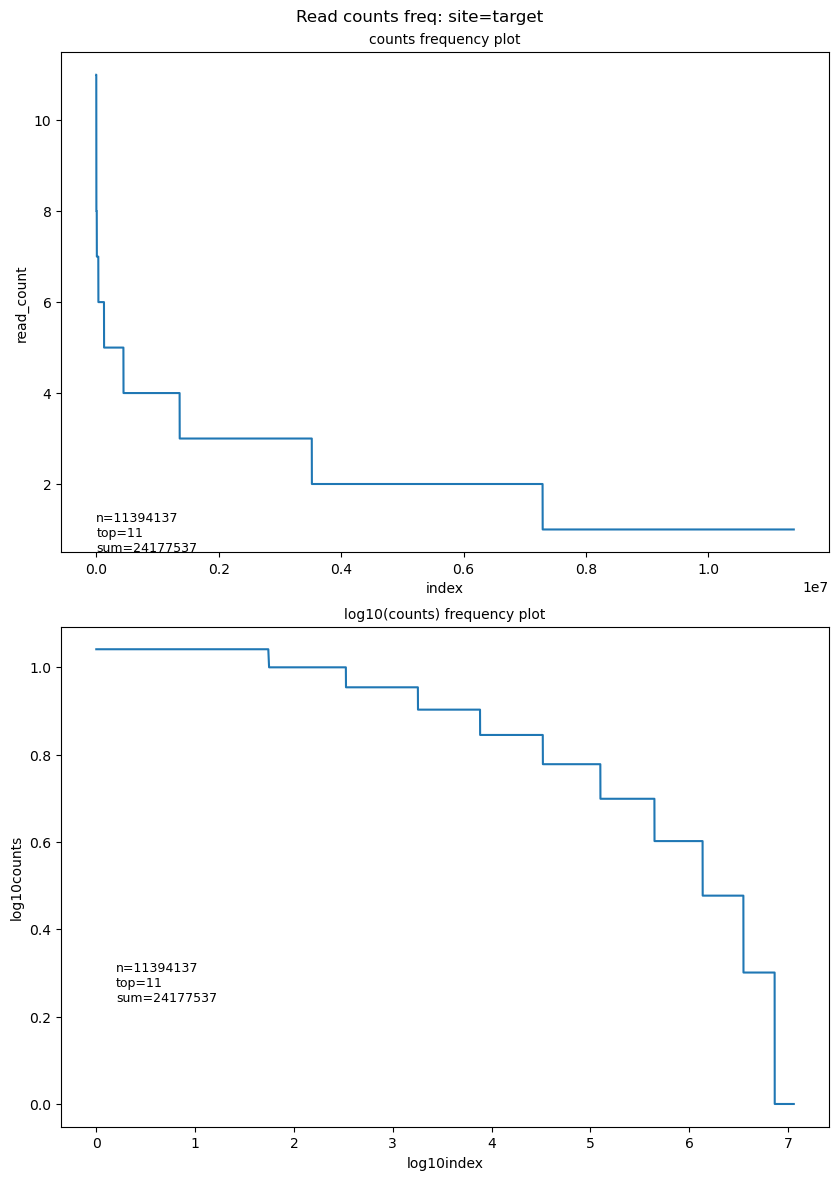

In [59]:
rtdf = process_make_readtable_pd(cdf.copy(),
                                   sampdf,
                                   bcfile=bcfile, 
                                   outdir=outdir, 
                                   cp=cp)
rtdf

Note that data from the sample information spreadsheet has now been integrated into the read table. The type value has been set from the libtag and the spike sequence. The label, rtprimer number, and brain id has been set from matching the SSI sequence. 

Since this is a small dataset, and read depth is thus low, a read threshold of 2 is reasonable. 

# process_make_vbctable_pd()

So far the data tables have been read-oriented (each row is a read). Now we are ready to move toward a viral barcode-oriented format, with each row representing a viral barcode, which represents a single neuron. And this is the step where we will remove all unmatched/invalid rows, and threshold on the read_count value we checked above. 

After data thresholding and cleaning, and dropping some redundant columns, this function aggregates on the viral barcode and sums the UMI count. This function takes less than a minute.  


In [58]:
vdf = process_make_vbctable_pd(rtdf.copy(),
                               outdir=outdir,
                               cp=cp)
vdf

INFO:root:dropping redundant readtable columns: libtag ssi rtprimer vbc_read  
INFO:root:DF before removing nomatch: 16931326
INFO:root:DF after removing nomatch/NaN: 13059827
INFO:root:thresholding by read count. inj=3 target=2 len=13059827
INFO:root:DF after threshold inj=3 tar=2: 8388770
INFO:root:DF after umi/label collapse: 350320


,vbc_read_col,label,type,umi_count,read_count,brain,region,site
0,AAAAAAATATATTTCGACCGCTGCGGGTTT,BC16,real,1,4,YW144,CP,target
1,AAAAAAATCCATTCAGCGGGCGGGATTTCT,BC16,real,14,111,YW144,CP,target
2,AAAAAAATCCGCATTCTATGCGCACTTTCC,BC16,real,1,9,YW144,CP,target
3,AAAAAAATTTCAGCCCTATGGAGCTCCCAG,BC2,real,2,13,YW143,ACB,target
4,AAAAAAATTTCAGCCCTATGGAGCTCCCAG,BC6,real,2,8,YW143,BLAa,target
...,...,...,...,...,...,...,...,...
350315,TTTTTTTGTGTTCACTGATAGGTATTGATC,BC25,lone,1,4,,L1 ctrl,target-control
350316,TTTTTTTGTTAGACGCACATGGTCTAGAGT,BC17,real,2,8,YW144,MTN,target
350317,TTTTTTTGTTCACACGTACAACCCGCATAG,BC4,real,1,9,YW143,CP,target
350318,TTTTTTTGTTCACACGTACAACCCGCATAG,BC6,real,1,4,YW143,BLAa,target


Note that the number of rows has now dropped from ~16M to ~350K, and we have per-barcode umi_count and (aggregate) read_count for each UMI.     

# process_make_matrices_pd()

For each brain, we pivot the real VBCs against the SSI/labelled site to create a 2D matrix, with the value being the UMI count for that VBC in that site.
We do the same operation for real VBCs filtered by the thresholds and requirements as defined in the config file. 
We do the same operation for the spike-in barcodes. 
Within each target area, we then normalize the filtered real UMI count by the total spike-in UMI count for that area: 

![title](img/normalization.png)

The results are pre-brain normalized barcode matrices, labelled by brain. E.g. YW144.nbcm.tsv

The file names as follows:
rbcm   = raw real barcode matrix
fbcmdf = filtered (real) barcode matrix
sbcm   = spike-in matrix
nbcm   = normalized barcode matrix
scbcm  = scaled normalized barcode matrix. 

The scale normalized matrix forces all values to 0.0 - 1.0 for usage in heatmap plots that require scaled values. 

This function should run in less than 30 seconds. Since this function doesn't produce a single dataframe, we print a less-pretty version of the normalized matrices. All the matrices are saved as TSV files in the out directory.  


In [73]:
norm_dict = process_make_matrices_pd(vdf.copy(),
                          exp_id = expid,  
                          outdir=outdir, 
                          cp=cp)
for bid in norm_dict.keys():
    print(f'brain={bid}:\n{norm_dict[bid]}\n')

/Users/hover/miniconda3/envs/mapseq2/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
INFO:root:done with brain=YW143
/Users/hover/miniconda3/envs/mapseq2/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
INFO:root:done with brain=YW144
INFO:root:got dict of 2 normalized barcode matrices. returning.


brain=YW143:
label                           BC1        BC2  BC3        BC4        BC5  \
vbc_read_col                                                                
AAAAAACTCTGTGAATGTTTAACTGCAAGT  0.0   0.000000  0.0  76.510817   1.909901   
AAAAAATCTTCTTCGCCTAGGCGTTCCAGG  0.0   0.000000  0.0   0.000000   0.000000   
AAAAACCGGGTTCCTCTTCTCGGCCATTTA  0.0   0.000000  0.0   0.000000   9.549505   
AAAAACGAGGGGCGGATGGCGTAGGAGGGC  0.0   0.000000  0.0   0.000000   5.729703   
AAAAACGGAGGCAACCCATCCCATTCGTTC  0.0  22.627566  0.0   4.637019   1.909901   
...                             ...        ...  ...        ...        ...   
TTTTTTGGGTTCGAATGCGTACTTTTTGGC  0.0  11.313783  0.0  97.377404   0.000000   
TTTTTTGGTGCGGGATTTTGCTTTTTTTGT  0.0   0.000000  0.0   0.000000  28.648515   
TTTTTTGTTCTAATATTGAGTGTATTTGAG  0.0   0.000000  0.0  20.866587   0.000000   
TTTTTTTAGCAGGGGCCTATAAGAGTGCAG  0.0   0.000000  0.0   0.000000   5.729703   
TTTTTTTCTAATCTACTATCAATCTCTTTT  0.0   0.000000  0.0   0.000000 

# Output files

Much more data is produced than is reflected in this notebook. To further investigate you can examine the output directory to open those files. 

In [74]:
flist = os.listdir(outdir)
flist.sort()
flist

['.DS_Store',
 'M205.htna24.binarized.pdf',
 'M205.htna24:YW143.binarized.pdf',
 'M205.htna24:YW144.binarized.pdf',
 'M205.mapseq.conf',
 'M205_sampleinfo.xlsx',
 'YW143.fbcmdf.tsv',
 'YW143.nbcm.tsv',
 'YW143.rbcm.tsv',
 'YW143.sbcm.tsv',
 'YW143.scbcm.tsv',
 'YW144.fbcmdf.tsv',
 'YW144.nbcm.tsv',
 'YW144.rbcm.tsv',
 'YW144.sbcm.tsv',
 'YW144.scbcm.tsv',
 'collapse.out',
 'component_count.tsv',
 'components.txt',
 'edgelist.txt',
 'fastq',
 'fastq.out',
 'indexes',
 'inj-counts.pdf',
 'multi_components.json',
 'read1read2.tsv',
 'read_collapsed.tsv',
 'readtable.out',
 'seqmapdict.json',
 'stats.202410142023.json',
 'target-counts.pdf',
 'unique_sequences.bt2.sam',
 'unique_sequences.btdf.tsv',
 'vbc_read.fulldf.tsv',
 'vbc_read.unique.fasta',
 'vbc_read.unique.tsv']

# Further data analysis

For simple data validation, we find it useful to create binarized plots, organized hierarchically. 
The y-axis is all the viral barcodes, while the x-axis is the target areas. For each barcode, the target area is given color if any UMIs are present. We have hierarchically arranged the VBCs such that all VBCs that project to any combination of target areas are grouped together. The vertical height of the color block in any target area reflects the number of projections. And blocks arraned horizontally in line with one another represent neurons with projections to multiple target areas. This allows the identification of projection motifs.

Since in this case we have two brains with the same target areas, obvious patterns across them are likely to reflect biological reality. 


INFO:root:plotting file: YW143.nbcm.tsv
INFO:root:wrote plot(s) to /Users/hover/project/mapseq/M205.htna24/M205.htna24:YW143.binarized.pdf


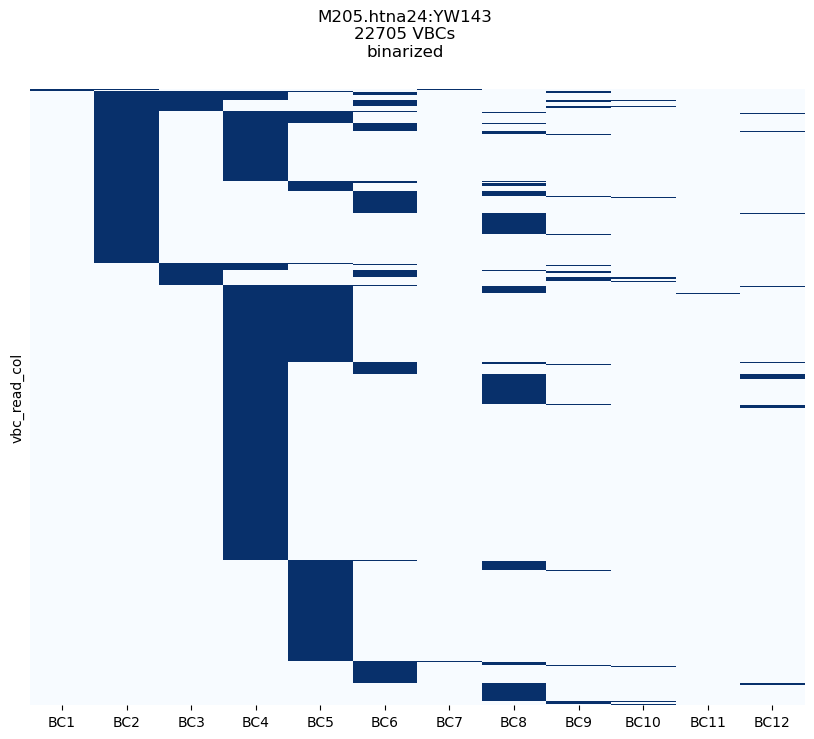

In [75]:
infile = f'{outdir}/YW143.nbcm.tsv'
make_plot_binarized(cp, infile, label=f'{expid}:YW143') 

INFO:root:plotting file: YW144.nbcm.tsv
INFO:root:wrote plot(s) to /Users/hover/project/mapseq/M205.htna24/M205.htna24:YW144.binarized.pdf


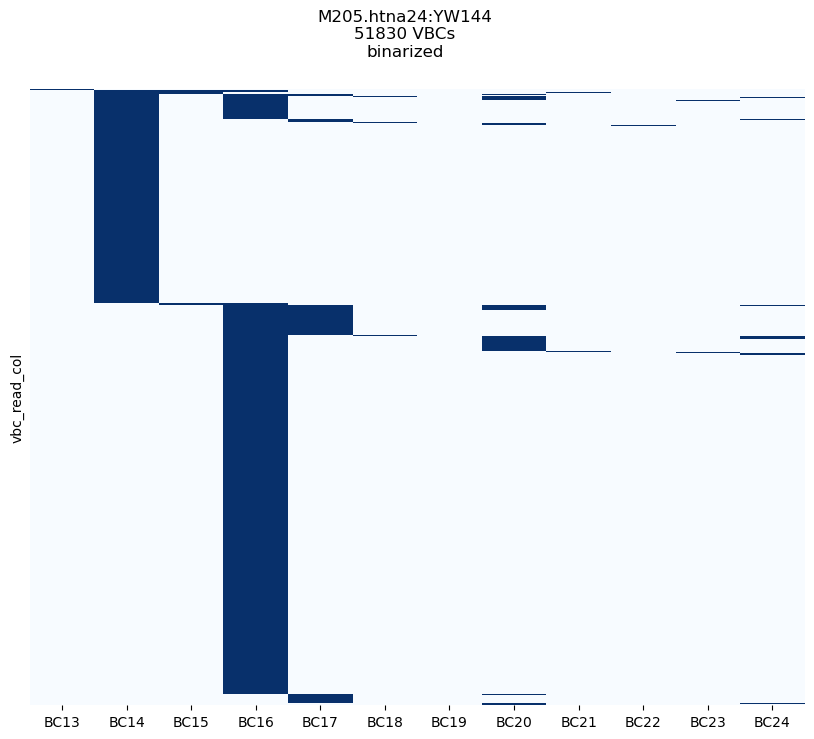

In [76]:
infile = f'{outdir}/YW144.nbcm.tsv'
make_plot_binarized(cp, infile, label=f'{expid}:YW144') 